In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 0

Exps = [{'p': 0.9, 'q': 0.4},
        {'p': 0.9, 'q': 0.01},
        {'p': 0.7, 'q': 0.1},
        {'p': 0.5, 'q': 0.1},
        {'p': 0.7, 'q': 0.015},
        {'p': 0.3, 'q': 0.1}]

# Signal parameters
K = 3
n_signals = 25
params = 4
n_p = 0.1

# Model parameters
fts = 150
epochs = 750
lr = 0.001

# Graph Density

## Graph fixed

Filter norm 375.9358438380378
Filter norm 128.66323341107488
Filter norm 102.24261138819794
Filter norm 70.66734981557622
Filter norm 82.1389248703112
Filter norm 47.87907156516507


<Figure size 432x288 with 0 Axes>

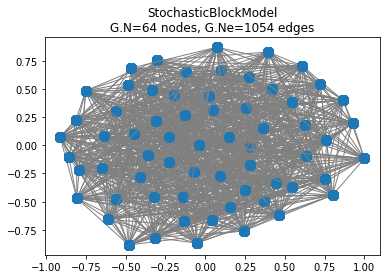

<Figure size 432x288 with 0 Axes>

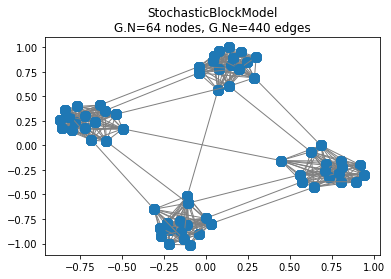

<Figure size 432x288 with 0 Axes>

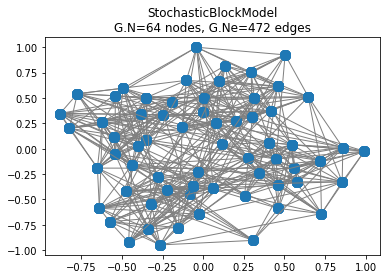

<Figure size 432x288 with 0 Axes>

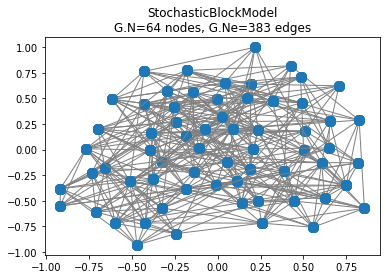

<Figure size 432x288 with 0 Axes>

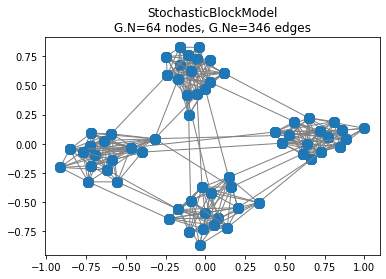

<Figure size 432x288 with 0 Axes>

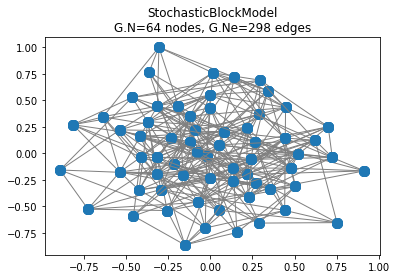

In [2]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
G_params = {}
G_params['type'] = ds.SBM
G_params['N'] = 64
G_params['k'] = 4
G_params['type_z'] = ds.CONT

# Create graphs and filters
hs = np.random.rand(K)
hs /= np.sum(hs)

Graphs = []
legend = []
Hs = []
for exp in Exps:
    G_params['p'] = exp['p']
    G_params['q'] = exp['q']
    G = ds.create_graph(G_params, SEED)
    Graphs.append(G)
    plt.figure()
    G.plot()

    x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
    print('Filter norm', np.linalg.norm(x_dw.H))
    Hs.append(x_dw.H/np.linalg.norm(x_dw.H))
    
    legend.append('Edges: {} p: {} q: {}'
                  .format(G.Ne, exp['p'], exp['q']))

In [4]:
err = np.zeros((len(Exps), n_signals, epochs))
err_wrt_n = np.zeros((len(Exps), n_signals, epochs))
weight_norm = np.zeros((len(Exps), n_signals))
start_time = time.time()
for i in range(n_signals):
    for j, H in enumerate(Hs):
        dec = GraphDecoder(fts, H, 1)
        weight_norm[j, i] = np.linalg.norm(dec.conv.weight.data.numpy().squeeze())
                
        Lambda, V = utils.ordered_eig(H)
        x = np.real(ds.bandlimited_signal(Lambda, V, params))
        x_n = ds.GraphSignal.add_noise(x, n_p)
        model = Model(dec, epochs=epochs, learning_rate=lr)
        err_wrt_n[j, i, :], err[j, i, :], _ = model.fit(x_n, x)

    print(i, end=' ', flush=True)

print('--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 --- 3.244766104221344 minutes ---


[12.25072891 12.24100174 12.23757336 12.28530109 12.2432214  12.25480793]


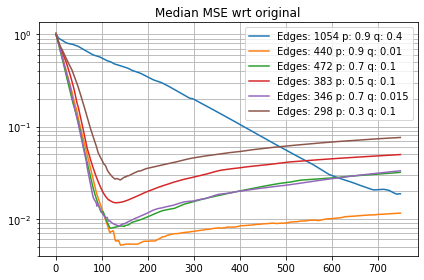

In [5]:
print(np.mean(weight_norm, axis=1))

# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

## Random Graphs

In [6]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Common graph parameters
G_params = {}
G_params['type'] = ds.SBM
G_params['N'] = 64
G_params['k'] = 4
G_params['type_z'] = ds.CONT

# Create graphs parameters
legend = []
Gs = []
for exp in Exps:
    G_params = {}
    G_params['type'] = ds.SBM
    G_params['N'] = 64
    G_params['k'] = 4
    G_params['type_z'] = ds.CONT
    G_params['p'] = exp['p']
    G_params['q'] = exp['q']
    Gs.append(G_params)

In [7]:
err = np.zeros((len(Exps), n_signals, epochs))
err_wrt_n = np.zeros((len(Exps), n_signals, epochs))
weight_norm = np.zeros((len(Exps), n_signals))
edges = np.zeros((len(Exps), n_signals))
start_time = time.time()
seed = SEED
for i in range(n_signals):
    hs = np.random.rand(K)
    hs /= np.sum(hs)
    for j, G_param in enumerate(Gs):
        G = ds.create_graph(G_param, seed)
        H = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs).H
        H /= np.linalg.norm(H)
        edges[j, i] = G.Ne

        dec = GraphDecoder(fts, H)
        weight_norm[j, i] = np.linalg.norm(dec.conv.weight.data.numpy().squeeze())
        
        Lambda, V = utils.ordered_eig(H)
        x = np.real(ds.bandlimited_signal(Lambda, V, params))
        
        x_n = ds.GraphSignal.add_noise(x, n_p)
        model = Model(dec, epochs=epochs, learning_rate=lr)
        err_wrt_n[j, i, :], err[j, i, :], _ = model.fit(x_n, x)

    seed += 1
    print(i, end=' ', flush=True)

print('--- {} minutes ---'.format((time.time()-start_time)/60))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 --- 4.418824684619904 minutes ---


[0.12250729 0.12241002 0.12237573 0.12285301 0.12243221 0.12254808]


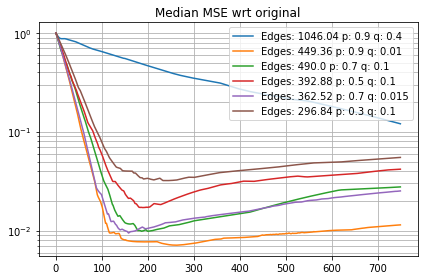

In [8]:
print(np.mean(weight_norm, axis=1))

# Create legend
mean_edges = np.mean(edges, axis=1)
legend  = []
for i, exp in enumerate(Exps):
    legend.append('Edges: {} p: {} q: {}'
                  .format(mean_edges[i], exp['p'], exp['q']))

# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

In [9]:
plt.show()